In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
import nltk
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('omw-1.4')
# For BoW & TF-IDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv('flipitnews-data.csv')

In [3]:
df.head()

,Category,Article
0,Technology,tv future in the hands of viewers with home th...
1,Business,worldcom boss left books alone former worldc...
2,Sports,tigers wary of farrell gamble leicester say ...
3,Sports,yeading face newcastle in fa cup premiership s...
4,Entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
df.shape

(2225, 2)

In [5]:
df['Category'].value_counts()

Sports           511
Business         510
Politics         417
Technology       401
Entertainment    386
Name: Category, dtype: int64

<Axes: >

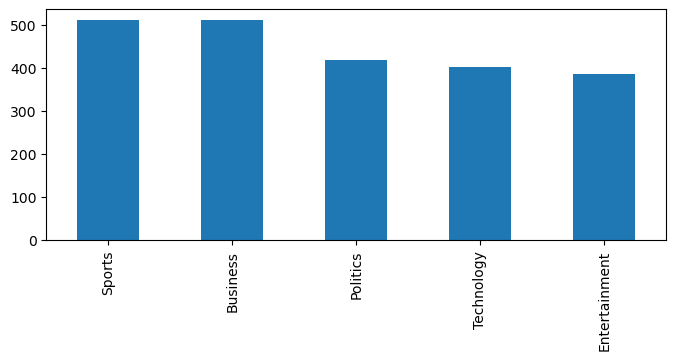

In [6]:
plt.figure(figsize=(8,3))
df['Category'].value_counts().plot(kind='bar')

# Text processing

In [7]:
df['Article'] = df['Article'].apply(lambda x: x.lower())
df['Article'] = df['Article'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
df['Article'] = df['Article'].apply(lambda x: nltk.word_tokenize(x))

In [9]:
stop_words = nltk.corpus.stopwords.words('english')
df['Article'] = df['Article'].apply(lambda x: [word for word in x if word not in stop_words])


In [10]:
def text_process(text):
    # set to lower case
    #text = text.lower()

    # remove punctuation
    #text = re.sub('[^a-zA-Z]', ' ', text)

    # word tokenize
    #words = nltk.word_tokenize(text)

    # remove stopwords
    #filtered_words = [word for word in words if word not in nltk.corpus.stopwords.words('english')]

    # lemmatization
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
    new_text = ' '.join(lemmatized_words)

    return new_text

df['Article'] = df['Article'].apply(text_process)
    
    

In [11]:
df['Article'].head()

0    tv future hand viewer home theatre system plas...
1    worldcom bos left book alone former worldcom b...
2    tiger wary farrell gamble leicester say rushed...
3    yeading face newcastle fa cup premiership side...
4    ocean twelve raid box office ocean twelve crim...
Name: Article, dtype: object

# Data Transformation

In [12]:
df['Category'] = df['Category'].map({'Business': 0, 'Entertainment': 1, 'Politics': 2, 'Sports': 3, 'Technology': 4})

In [13]:
df.head()

,Category,Article
0,4,tv future hand viewer home theatre system plas...
1,0,worldcom bos left book alone former worldcom b...
2,3,tiger wary farrell gamble leicester say rushed...
3,3,yeading face newcastle fa cup premiership side...
4,1,ocean twelve raid box office ocean twelve crim...


# TF-IDF

In [14]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['Article']).toarray()
y = np.array(df['Category'].values)

In [15]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True, stratify=y)
print('Number of rows in train set :', x_train.shape[0])
print('Number of rows in validation set :', x_val.shape[0])

Number of rows in train set : 1668
Number of rows in validation set : 557


# Naive bayes classifier

In [16]:
nb = MultinomialNB()
nb.fit(x_train, y_train)

MultinomialNB()

In [17]:
# calculate accuracy
nb_train_acc = nb.score(x_train, y_train)
nb_val_acc = nb.score(x_val, y_val)

print('Naive Bayes Train Accuracy :', nb_train_acc)
print('Naive Bayes Validation Accuracy :', nb_val_acc)

Naive Bayes Train Accuracy : 0.986810551558753
Naive Bayes Validation Accuracy : 0.9766606822262118


In [18]:
# calculating confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = nb.predict(x_val)
cm = confusion_matrix(y_val, y_pred)
print(cm)

[[122   1   3   0   2]
 [  1  93   2   0   1]
 [  1   0 103   0   0]
 [  0   0   0 128   0]
 [  2   0   0   0  98]]


In [19]:
#calculate precision, recall, f1-score
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print('Precision :', precision)
print('Recall :', recall)
print('F1 Score :', f1)

Precision : 0.9768751906613521
Recall : 0.9766606822262118
F1 Score : 0.9766434550988928


In [20]:
# calculate classification report
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       128
           1       0.99      0.96      0.97        97
           2       0.95      0.99      0.97       104
           3       1.00      1.00      1.00       128
           4       0.97      0.98      0.98       100

    accuracy                           0.98       557
   macro avg       0.98      0.98      0.98       557
weighted avg       0.98      0.98      0.98       557



In [21]:
# Functionalize code
def model_train_eval(model, x_train, y_train, x_val, y_val):
    model.fit(x_train, y_train)
    train_acc = model.score(x_train, y_train)
    val_acc = model.score(x_val, y_val)
    y_pred = model.predict(x_val)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    print('Train Accuracy :', train_acc)
    print('Validation Accuracy :', val_acc)
    print('Precision :', precision)
    print('Recall :', recall)
    print('F1 Score :', f1)
    print(classification_report(y_val, y_pred))
    print('---------------')
    return model



In [22]:
# Decision Tree calssifier
dt = DecisionTreeClassifier()
dt = model_train_eval(dt, x_train, y_train, x_val, y_val)

Train Accuracy : 1.0
Validation Accuracy : 0.8527827648114902
Precision : 0.8534322455289048
Recall : 0.8527827648114902
F1 Score : 0.8525485548658868
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       128
           1       0.85      0.81      0.83        97
           2       0.77      0.82      0.79       104
           3       0.92      0.96      0.94       128
           4       0.84      0.85      0.85       100

    accuracy                           0.85       557
   macro avg       0.85      0.85      0.85       557
weighted avg       0.85      0.85      0.85       557

---------------


In [23]:
# randomforest classifier
rf = RandomForestClassifier()
model_rf = model_train_eval(rf, x_train, y_train, x_val, y_val)

Train Accuracy : 1.0
Validation Accuracy : 0.9748653500897666
Precision : 0.9750584307004643
Recall : 0.9748653500897666
F1 Score : 0.9748390463794084
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       128
           1       0.99      0.95      0.97        97
           2       0.96      0.96      0.96       104
           3       0.98      0.99      0.98       128
           4       0.99      0.98      0.98       100

    accuracy                           0.97       557
   macro avg       0.98      0.97      0.97       557
weighted avg       0.98      0.97      0.97       557

---------------


In [28]:
y_train.shape

(1668,)

In [29]:
# knn classifier
knn = KNeighborsClassifier( n_neighbors=5)
model_knn = model_train_eval(knn, x_train, y_train, x_val, y_val)

AttributeError: 'NoneType' object has no attribute 'split'

In [31]:
print(x_train is None, y_train is None, x_val is None, y_val is None)
print(type(x_train), type(y_train), type(x_val), type(y_val))

False False False False
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


# LSTM model

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, GRU, SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [35]:
df_lstm = pd.read_csv('flipitnews-data.csv')
df_lstm.head()

,Category,Article
0,Technology,tv future in the hands of viewers with home th...
1,Business,worldcom boss left books alone former worldc...
2,Sports,tigers wary of farrell gamble leicester say ...
3,Sports,yeading face newcastle in fa cup premiership s...
4,Entertainment,ocean s twelve raids box office ocean s twelve...


In [36]:
df_lstm['Article'] = df_lstm['Article'].apply(lambda x: x.lower())

In [37]:
# parameters
max_features = 5000
maxlen = 100
embedding_size = 100
batch_size = 1000
epochs = 5

# Tokenization
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df_lstm['Article'])
sequences = tokenizer.texts_to_sequences(df_lstm['Article'])
data = pad_sequences(sequences, maxlen=maxlen)

# Label Encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_lstm['Category'])
labels = tf.keras.utils.to_categorical(labels)


In [38]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, shuffle=True, stratify=labels)

In [40]:
# load glove embeddings
def load_glove_embeddings(embedding_path, embedding_dim, tokenizer, max_features):
    embeddings_index = {}
    with open(embedding_path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    # Only use the top max_features items from word_index
    limited_word_index = {word: index for word, index in tokenizer.word_index.items() if index < max_features}

    # Note: We use min(max_features + 1, len(limited_word_index) + 1) to handle cases where unique words < max_features
    embedding_matrix = np.zeros((min(max_features + 1, len(limited_word_index) + 1), embedding_dim))
    for word, i in limited_word_index.items():
        if i > max_features:  # Safety check to ensure we do not exceed max_features
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = load_glove_embeddings('glove.6B.100d.txt', embedding_size, tokenizer, max_features)


In [44]:
vocab_size = len(tokenizer.word_index) + 1


In [47]:
print(vocab_size)

29727


In [60]:
# model building
# model_lstm = Sequential(
#     Embedding(input_dim=max_features, output_dim=embedding_size, input_length=maxlen, 
#               weights=[embedding_matrix], trainable=False, name = 'embedding_layer'),
#     LSTM(100, dropout=0.2, recurrent_dropout=0.2, name = 'lstm_layer'),
#     Dense(5, activation='softmax', name = 'output_layer')#, name = 'sequential_model'
# )
epochs = 20
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_features, output_dim=embedding_size, #input_length=maxlen, 
              weights=[embedding_matrix], trainable=False, name = 'embedding_layer'))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, name = 'lstm_layer'))
model_lstm.add(Dense(5, activation='softmax', name = 'output_layer'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# use early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#model training
model_lstm.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
          validation_data=(X_test, y_test), callbacks=[early_stopping])


# model evaluation
loss, accuracy = model_lstm.evaluate(X_test, y_test)
print('Test Loss :', loss)

# classification report
y_pred = model_lstm.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)
print(classification_report(y_test_argmax, y_pred))

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.1850 - loss: 1.6396 - val_accuracy: 0.2787 - val_loss: 1.5814
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 865ms/step - accuracy: 0.2792 - loss: 1.5795 - val_accuracy: 0.3618 - val_loss: 1.5284
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3599 - loss: 1.5238 - val_accuracy: 0.4472 - val_loss: 1.4711
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4246 - loss: 1.4791 - val_accuracy: 0.5640 - val_loss: 1.4130
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4853 - loss: 1.4316 - val_accuracy: 0.6157 - val_loss: 1.3513
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 890ms/step - accuracy: 0.5312 - loss: 1.3722 - val_accuracy: 0.6360 - val_loss: 1.2719
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5442 - loss: 1.3197 - val_accuracy: 0.6472 - val_loss: 1.1725
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 924ms/step - accuracy: 0.5740 - loss: 1.2339 - val_accuracy: 0.7146 - val_loss: 1.0427
Epoch 9

In [64]:
import pickle
with open('model_lstm.pkl', 'wb') as f:
    pickle.dump(model_lstm, f)

# Inference

In [61]:
def predict_category(text):
    text = text.lower()

    #tokenize
    seq = tokenizer.texts_to_sequences([text])

    #padding
    padded_seq = pad_sequences(seq, maxlen=maxlen)

    #prediction
    pred = model_lstm.predict(padded_seq)

    print('This was predicted as :', pred)

    pred_label_index = np.argmax(pred, axis=1)
    pred_label = label_encoder.inverse_transform(pred_label_index)[0]
    return pred_label

#Example
text = 'The Indian cricket team won the world cup'
print(predict_category(text))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
This was predicted as : [[0.00927853 0.05485646 0.01495286 0.91565657 0.00525557]]
Sports


2025-01-20 00:22:47.710 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-20 00:22:50.771 
  command:

    streamlit run c:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-01-20 00:22:50.773 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-20 00:22:50.775 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-20 00:22:50.776 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-20 00:22:50.779 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-20 00:22:50.781 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-20 00:22:50.784 Thread 'MainThread': missi